# Homework 7: A/B testing and fuzzy matching (50 points)

**Reading**: Textbook chapter [12](https://www.inferentialthinking.com/chapters/12/Comparing_Two_Samples) .

Please complete this notebook by filling in the cells provided. Before you begin, execute the following cell to load the needed functions. Each time you start your server, you will need to execute this cell again to load them.  

Homework 7 is due Wednesday, 12/05 at 2:00pm. Late work will not be accepted.  

In [23]:
# Don't change this cell; just run it. 

import numpy as np
from datascience import *
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

## 1. Birth weight data (25 points)##

We discussed in class a dataset that contains the following variables for 1,174 mother-baby pairs: the baby’s birth weight in ounces, the number of gestational days, the mother’s age in completed years, the mother’s height in inches, pregnancy weight in pounds, and whether or not the mother smoked during pregnancy.  The code to read the data is in the next cell, and the data file is on Canvas.


In [24]:
baby = Table.read_table('baby.csv')
baby

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False
138,244,33,62,178,False
132,245,23,65,140,False
120,289,25,62,125,False
143,299,30,66,136,True
140,351,27,68,120,False


The analysis in class (a permutation test for the difference in means) showed that there is strong evidence for unequal distributions of birth weights for smoker and non-smoker mothers. Here we will investigate differences in BMI between mothers who smoked and did not.

Body Mass Index (BMI) is a person’s weight in kilograms divided by the square of height in meters.  BMI can be used to screen for weight categories that may lead to health problems but it is not diagnostic of the health of an individual.

#### Question 1

Calculate the BMI for the mothers in this dataset and save it in a variable called `bmi`

In [25]:
bmi= (baby.column('Maternal Pregnancy Weight')/2.205) / (baby.column('Maternal Height')/39.37)
baby = baby.with_column('BMI', bmi)
baby

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker,BMI
120,284,27,62,100,False,28.7982
113,282,33,64,135,False,37.6626
128,279,28,64,115,True,32.083
108,282,23,67,125,True,33.3113
136,286,25,62,93,False,26.7823
138,244,33,62,178,False,51.2608
132,245,23,65,140,False,38.4567
120,289,25,62,125,False,35.9977
143,299,30,66,136,True,36.7919
140,351,27,68,120,False,31.5086


#### Question 2

Similarly to what we did in class, generate two plots: (i) overlapping histograms of mother BMI for smokers and non-smokers; (ii) back-to-back boxplots of mother BMI for smokers and non-smokers.

Interpret the plots.


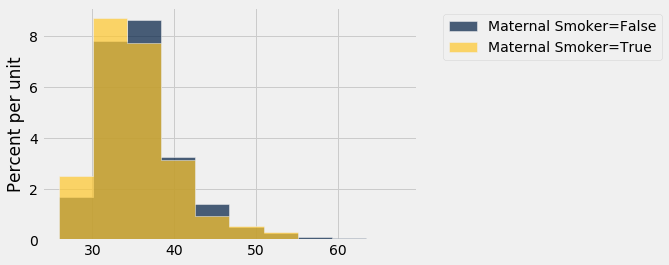

In [26]:
# histograms
smoking_and_bmi = baby.select('Maternal Smoker', 'BMI')
#smoking_and_bmi.group('Maternal Smoker')
smoking_and_bmi.hist('BMI', group = 'Maternal Smoker')

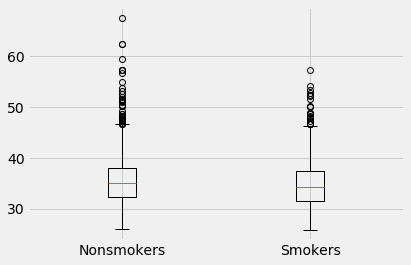

In [27]:
# boxplots
plots.boxplot([baby.where('Maternal Smoker',False).column('BMI'),baby.where('Maternal Smoker',True).column('BMI')],
             labels=("Nonsmokers","Smokers"));

*Comment here on the plots:*

Although nonsmokers have a greater range of BMIs, overall, the spreads look fairly similar. The means are about the same as are the IQRs and lower tail lengths. The median and IQR do seem to be slightly lower for smokers than for nonsmokers.

#### Question 3 (means)

We want to investigate if the distributions of the BMI in mothers who smoke and mother who do not smoke are the same. 
The null and alternative hypotheses are similar to what we stated in the class. We will use first the following test statistic: **the difference in BMI sample means** (between smokers and non-smokers).  

Write the code that generates a null distribution for this test statistic (using shuffling/permutations) and calculate the p-value associated with this test statistic.


In [223]:
bmi = smoking_and_bmi.select('BMI')
group_labels = baby.select('Maternal Smoker')

In [246]:
def simulations_hist(collect, num_iters):
     diff_hist = make_array()

     for i in np.arange(num_iters):
        shuffled_bmi = bmi.sample(with_replacement = False).column(0)
        shuffled_tbl = group_labels.with_column('Shuffled BMI', shuffled_bmi)
        collect_tbl = shuffled_tbl.group(0, collect)
        hist_diff = (collect_tbl.column(1).item(1) - collect_tbl.column(1).item(0))
        diff_hist = np.append(diff_hist, hist_diff)
     return diff_hist

def simulations(collect, num_iters):
    differences = make_array()
   
    for i in np.arange(num_iters):
        shuffled_bmi = bmi.sample(with_replacement = False).column(0)
        shuffled_tbl = group_labels.with_column('Shuffled BMI', shuffled_bmi)
        collect_tbl = shuffled_tbl.group(0, collect)
        new_diff = abs(collect_tbl.column(1).item(1) - collect_tbl.column(1).item(0))
        differences = np.append(differences, new_diff)
    return differences

def get_pvalue(collect, differences):
    collect_tbl = smoking_and_bmi.group('Maternal Smoker', collect)
    collected = collect_tbl.column(1)
    observed_difference = abs(collected.item(1) - collected.item(0)) 
#np.count_nonzero(differences > 1)
#np.count_nonzero(differences >= observed_difference), len(differences)
    p_collected = (np.count_nonzero(differences >= observed_difference)) / len(differences)
    return p_collected


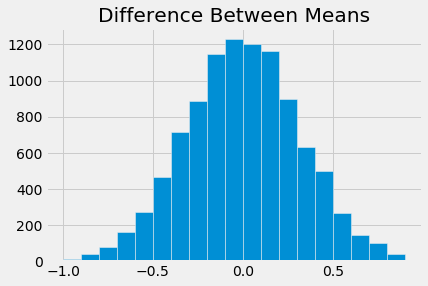

In [247]:
diff_hist = simulations_hist(np.mean, 10000)
plots.hist(diff_hist,bins=np.arange(-1,1,0.1))
plots.title("Difference Between Means");

In [248]:
differences = simulations(np.mean, 10000)
p_mean = get_pvalue(np.mean, differences)
p_mean

0.0159

#### Question 4 (medians)

Repeat what is asked in Question 3 for the following test statistic: **the difference in BMI sample medians**.

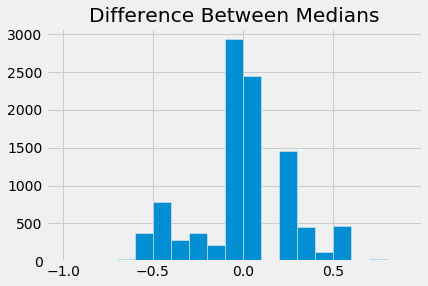

In [249]:
diff_med_hist = simulations_hist(np.median, 10000)
plots.hist(diff_med_hist,bins=np.arange(-1,1,0.1))
plots.title("Difference Between Medians");

In [250]:
differences_med = simulations(np.median, 10000)
p_median = get_pvalue(np.median, differences)
p_median

0.0141

#### Question 5 (Inter Quartile  Range or IQR)

Repeat what is asked in Question 3 for the following test statistic: **the difference in BMI sample IQRs**. Recall that IQR is the difference of the two quartiles.


In [229]:
def iqr(tbl):
    q3 = np.percentile(tbl,75)
    q1 = np.percentile(tbl,25)
    return q3 - q1

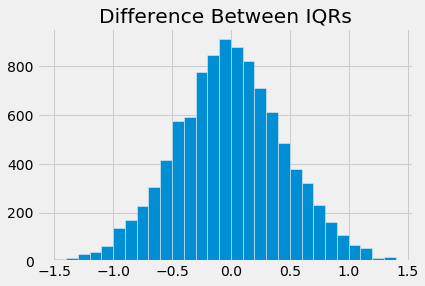

In [255]:
diff_iqr_hist = simulations_hist(iqr, 10000)
plots.hist(diff_iqr_hist,bins=np.arange(-1.5,1.5,0.1))
plots.title("Difference Between IQRs");

In [252]:
differences_iqr = simulations(iqr, 10000)
p_iqr = get_pvalue(iqr, differences)
p_iqr

0.5611

#### Question 6 (standard deviations)

Repeat what is asked in Question 3 for the following test statistic: **the difference in BMI sample standard deviations**.

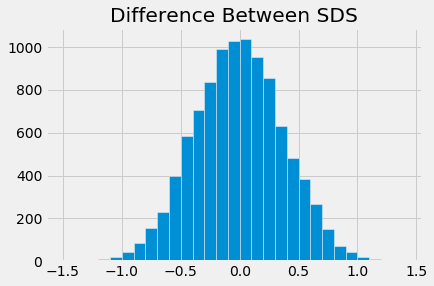

In [256]:
diff_sds_hist = simulations_hist(np.std, 10000) 
plots.hist(diff_sds_hist,bins=np.arange(-1.5,1.5,0.1))
plots.title("Difference Between SDS");

In [254]:
differences_sds = simulations(np.std, 10000) 
p_sds = get_pvalue(np.std, differences)
p_sds

0.2435

#### Question 7

Write a very brief discussion on the interpretation of the four p-values you calculated.

The p values for the differences in means and differences in medians are both significant as they are approximately between 0.01 and 0.02 each. This indicates that we reject the null hypothesis that the differences in center are not different.

The p values for the differences in IQR and standard deviation are not significant as they are both greater than 0.05. We fail to reject the null hypothesis that the differences in measures of spread are not different.

## 2. Plagiarism detector (25 points) ##

We will use the matching techniques discussed in Lecture 15 to construct **a naive plagiarism detector**. We modified the code from the class notebook in two ways: (i) we generalized it to q-character tokens; and (ii) we added space instead of # at the ends of the strings.

This code allows you to calculate the Jaccard distance for bigrams, trigrams etc.

In [152]:
#A Function to break a string into qgrams (q-character tokens)
#we'll pad the string with spaces on the front and end
def qgram(str,q):
    str = ' ' + str + ' '
    return([str[i:i+q] for i in range(len(str)-(q-1))])

#compute the jaccard similarity of two strings using trigrams
#call jaccard_sim3(string1,string2,True) to see intermediate values
#call jaccard_sim3(string1,sring2) or jaccard_sim(string1,string2,False) to just get the answer
def jaccard_simq(str1, str2,q,verbose=False): 
    set1 = set(qgram(str1,q)) 
    set2 = set(qgram(str2,q))
    common_tokens = set1.intersection(set2)
    all_tokens = set1.union(set2)
    if verbose:
        print('set1 =',set1)
        print('set2 =',set2)
        print('Intersection =',common_tokens)
        print('Union =',all_tokens)
        print('Common Tokens =',len(common_tokens),
              'Total Tokens =',len(all_tokens))
    return float(len(common_tokens) / len(all_tokens))


To familiarize yourself with the function, you should try it on several examples and with different values of q. The `verbose=True` option is useful when you want to understand what the function is doing.

In [4]:
jaccard_simq('the quick brown fox','fox quick brown the',2,True)

set1 = {'wn', 'br', 'ui', 'ox', ' q', ' b', 'ck', 'qu', 'n ', 'ow', 'fo', 'e ', 'th', 'k ', ' f', 'x ', 'ic', ' t', 'ro', 'he'}
set2 = {'wn', 'br', 'ox', 'ui', ' q', ' b', 'ck', 'qu', 'n ', 'ow', 'fo', 'e ', 'th', 'k ', ' f', 'x ', 'ic', ' t', 'ro', 'he'}
Intersection = {'wn', 'br', 'ox', 'ui', ' q', ' b', 'ck', 'qu', 'n ', 'ow', 'fo', 'e ', 'th', 'k ', ' f', 'x ', 'ic', ' t', 'ro', 'he'}
Union = {'wn', 'ox', ' q', ' b', 'ck', 'qu', 'n ', 'ow', 'fo', 'k ', 'ic', 'br', 'ui', 'e ', 'th', ' f', 'x ', ' t', 'ro', 'he'}
Common Tokens = 20 Total Tokens = 20


1.0

In [5]:
jaccard_simq('the quick brown fox','fox quick brown the',2)

1.0

In [6]:
jaccard_simq('the quick brown fox','fox quick brown the',4,True)

set1 = {'fox ', 'ck b', 'the ', ' qui', 'rown', 'k br', ' the', 'quic', 'uick', 'n fo', 'wn f', 'ick ', 'e qu', ' fox', ' bro', 'brow', 'he q', 'own '}
set2 = {'fox ', 'ox q', 'ck b', ' qui', 'rown', 'the ', 'k br', 'quic', ' the', 'uick', 'wn t', 'x qu', 'n th', 'ick ', ' fox', ' bro', 'brow', 'own '}
Intersection = {'fox ', 'ck b', 'the ', 'rown', ' qui', 'k br', 'quic', ' the', 'uick', 'ick ', ' fox', ' bro', 'brow', 'own '}
Union = {'fox ', 'ox q', ' qui', ' the', 'uick', 'n th', 'e qu', 'n fo', ' bro', 'he q', 'own ', 'ck b', 'the ', 'rown', 'k br', 'quic', 'wn t', 'x qu', 'wn f', 'ick ', ' fox', 'brow'}
Common Tokens = 14 Total Tokens = 22


0.6363636363636364

In [7]:
jaccard_simq('the quick brown fox','fox quick brown the',10)

0.2

The goal of this exercise is to use this function to investigate possible plagiarism in a homework assignment. A homework question asked students to define PageRank. The instructor was worried that the students will copy the answer from Wikipedia, so she/he decided to use that as a reference. The relevant part of the Wikipedia entry is saved in the file `original.txt` and the command below reads that file into a string.

In [8]:
open("original.txt","r").read()

'PageRank is a link analysis algorithm used by the Google Internet search engine that assigns a numerical weighting to each element of a hyperlinked set of documents, such as the World Wide Web, with the purpose of "measuring" its relative importance within the set. The algorithm may be applied to any collection of entities with reciprocal quotations and references. The numerical weight that it assigns to any given element E is also called the PageRank of E and denoted by PR(E).\nThe name "PageRank" is a trademark of Google, and the PageRank process has been patented (U.S. Patent 6,285,999 ). However, the patent is assigned to Stanford University and not to Google. Google has exclusive license rights on the patent from Stanford University. The university received 1.8 million shares in Google in exchange for use of the patent; the shares were sold in 2005 for $336 million.\nGoogle describes PageRank:\n“ \tPageRank relies on the uniquely democratic nature of the web by using its vast lin

Files containing the answer of five students (A,B,C,D, and E) are provided. They are read as strings using the code below. 

In [153]:
original=open("original.txt","r").read()
studentA=open("studentA.txt","r").read()
studentB=open("studentB.txt","r").read()
studentC=open("studentC.txt","r").read()
studentD=open("studentD.txt","r").read()
studentE=open("studentE.txt","r").read()


#### Question 1

One decision to make is the choice of q in the Jaccard distance (whether to use 2-character tokens, 20-character tokens etc.) 


Write one advantage and one disadvantage when using 2-character tokens.

(+): Accounts for potential typos in identifying overlap. 

(-): Because there are only 26 letters, there will inevitably be high overlap in 2 character tokens and these could be by chance rather than genuine plaigerism. 

Write one advantage and one disadvantage when using 20-character tokens.

(+): Rigorous in identifying plaigerism, would make copy pasters and reworders very obvious with higher scores. 

(-): Probably too large to notice if people are strong re-writers. If different words/synonyms are used (even if sentence structure is same), it would not pick up on it.

#### Question 2

Calculate the Jaccard distances between each of the five student responses and the original Wikipedia reference. This should be done for all q between 2 and 20.

Save the results in a table with 19 rows and 6 columns: (i) the first column shows the values of q; (ii) the next five columns show the Jaccard distances for the five student answers.

In [166]:
# the code that generates the table

q = np.arange(2, 21, 1) #column 1

def get_Jaccard(q, student):
    jaccard_values = make_array()
    for i in q:
        jaccard_values = np.append(jaccard_values, jaccard_simq(original, student, i))
    return jaccard_values

distances = Table.empty()
a= get_Jaccard(q, studentA)
b= get_Jaccard(q, studentB)
c= get_Jaccard(q, studentC)
d= get_Jaccard(q, studentD)
e= get_Jaccard(q, studentE)

distances = distances.with_column('q', q, 'Student A', a, 'Student B', b, 'Student C', c, 'Student D', d, 'Student E', e)


#(make_array('q', 'Student A', 'Student B', 'Student C', 'Student D', 'Student E'))
distances

/anaconda3/lib/python3.6/site-packages/datascience/tables.py:81: FutureWarning: Table.empty(labels) is deprecated. Use Table(labels)
  warnings.warn("Table.empty(labels) is deprecated. Use Table(labels)", FutureWarning)


q,Student A,Student B,Student C,Student D,Student E
2,0.713959,0.436647,0.449561,0.413242,0.454148
3,0.528192,0.261528,0.232156,0.244681,0.2847
4,0.457965,0.162698,0.128345,0.17714,0.200939
5,0.42492,0.108565,0.0793766,0.150758,0.166093
6,0.402108,0.0777298,0.0480556,0.131777,0.147793
7,0.387012,0.0540997,0.0283729,0.118185,0.134663
8,0.374911,0.0387063,0.0155738,0.108296,0.125763
9,0.365854,0.0269172,0.00841662,0.100334,0.120944
10,0.358409,0.0194725,0.00332651,0.0940755,0.117798
11,0.351749,0.0146953,0.00100402,0.0888252,0.11425


#### Question 3

Draw five overlaid line plots for the Jaccard distances of the five texts. The plot should show the Jaccard distances (on y-axis) against q (on x-axis). Make sure that it is clear which line corresponds to which student/answer.

Text(0,0.5,'Jaccard distance')

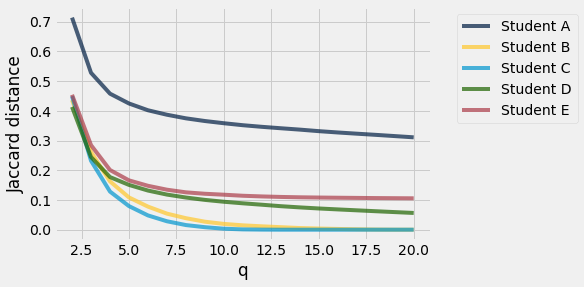

In [173]:
# the code to draw the overlaid line plots
distances.plot('q')
plots.ylabel('Jaccard distance')

#### Question 4

What do the distances you calculated say about the five students (A,B,C, D and E)? Is there evidence for plagiarism for any of them? Write a short discussion of your findings.


As expected, when we use shorter tokens, or smaller q's, the jaccard distance is significantly higher as there will inevitable be overlap as there are only so many 2 letter combinations in words that can be made. All the students follow the same curve pattern indicating the same amount of overlap.

It seems likely that student A plaigerized based on their way higher jaccard distance score than the other students across q's. 

#### Question 5

Do the length of the texts/answers affect the Jaccard distances? Would a plagiarized short paper (1-2 sentences) have a different Jaccard distance than a plagiarized long paper (few paragraphs)? Is this important for our five student scenario?

Here you assume that the reference (the original text) does not change.

This is an open-ended question. You can answer it by changing the length of a plagiarized text and calculating distances. You can argue it mathematically. 



In [238]:
# if you use code to make your argument
len(studentA), len(studentB), len(studentC), len(studentD), len(studentE), len(original)

(1243, 1368, 1076, 493, 610, 3098)

The length does affect the distances, because the length of the paper will change the denominator in the Jaccard calculation. The longer the paper, the more tokens it will have. Therefore, even with the same amount of plaigerism, the shorter paper will have a higher Jaccard distance than a longer paper. This is relevant to our five student scenario as Student D and student E have far shorter papers. If they had plaigerized, we would expect their numbers to be higher than others due to there being less tokens in the union, or overlap. Student A actually had the second longest paper, yet the Jaccard distance was way higher indicating plaigerism.